In [1]:
import numpy as np

In [33]:
def utility_crra(Y: float, gamma: float) -> float:
    """
    Constant Relative Risk Aversion (CRRA) utility function.
    U(Y) = Y^(1-gamma) for gamma != 1
    U(Y) = log(Y) for gamma = 1

    Parameters:
    -----------
    Y : float
        Budget allocation (0 to 1)
    gamma : float
        Risk aversion parameter (0 = risk neutral, higher = more risk averse)

    Returns:
    --------
    float : Utility value
    """
    if gamma == 1:
        # Log utility
        return np.log(np.maximum(Y, 1e-10))  # Avoid log(0)
    else:
        return Y ** (1 - gamma)

def deriv_u(Y: float, gamma: float) -> float:
    """
    Derivative of the CRRA utility function.

    Parameters:
    -----------
    Y : float
        Budget allocation (0 to 1)
    gamma : float
        Risk aversion parameter

    Returns:
    --------
    float : Derivative of utility
    """
    if gamma == 1:
        return 1 / np.maximum(Y, 1e-10)  # Avoid division by zero
    else:
        return (1 - gamma) * Y ** (-gamma)

def utility_quad(Y: float, gamma: float) -> float:
    """
    Quadratic utility function as an alternative.

    U(Y) = Y - 0.5 * gamma * Y^2

    Parameters:
    -----------
    Y : float
        Budget allocation (0 to 1)
    gamma : float
        Risk aversion parameter

    Returns:
    --------
    float : Utility value
    """
    return Y - 0.5 * gamma * Y ** 2


def deriv_u_quad(Y: float, gamma: float) -> float:
    """
    Derivative of the quadratic utility function.

    Parameters:
    -----------
    Y : float
        Budget allocation (0 to 1)
    gamma : float
        Risk aversion parameter

    Returns:
    --------
    float : Derivative of utility
    """
    return 1 - gamma * Y

In [52]:
gamma = .9
delta = 0.3
p = 0.5  # Probability of winning

Coop = 0.1  # Cooperation discount

V_wta = utility_quad(1,gamma) + delta * (p * utility_quad(1,gamma) + (1-p) * utility_quad(0,gamma))  # Winner-takes-all
V_coop = utility_quad(1-Coop, gamma) + delta * (
    p * utility_quad(1+Coop, gamma) + (1 - p) * utility_quad(0+Coop, gamma)
)

print("Value under winner-takes-all:", V_wta)
print("Value under cooperation:", V_coop)

# Now that we have the payoffs, we can analyze when cooperation is preferred
deltaPayoff = V_coop - V_wta
print("Delta Payoff (Cooperation - WTA):", deltaPayoff)

# now approximate the difference for small Coop
diff_approx = -deriv_u_quad(1, gamma) * Coop + delta * (
    p * deriv_u_quad(1, gamma) * Coop + (1 - p) * deriv_u_quad(0, gamma) * Coop
)
diff_approx = Coop * (-deriv_u_quad(1, gamma) + delta * (
    p * deriv_u_quad(1, gamma) + (1 - p) * deriv_u_quad(0, gamma)
))

diff_normal = -deriv_u_quad(1, gamma) + delta * (
    p * deriv_u_quad(1, gamma) + (1 - p) * deriv_u_quad(0, gamma)
)
print("Approximate Delta Payoff for small Coop:", diff_approx)

Value under winner-takes-all: 0.6325000000000001
Value under cooperation: 0.63315
Delta Payoff (Cooperation - WTA): 0.0006499999999999284
Approximate Delta Payoff for small Coop: 0.006500000000000003


Text(0.5, 0, 'Budget Allocation Y')

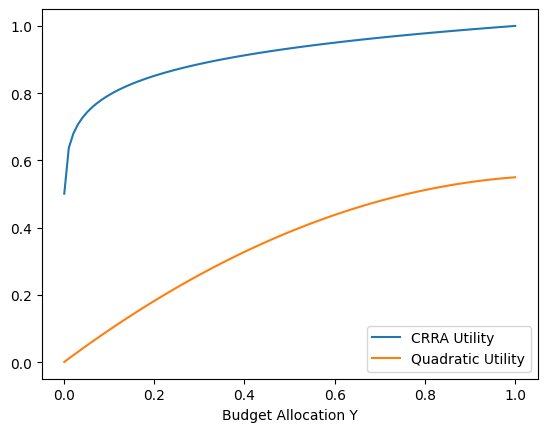

In [45]:
gamma = 0.9

Ys = np.linspace(0.001, 1, 100)
u_crra = [utility_crra(Y, gamma) for Y in Ys]
u_quad = [utility_quad(Y, gamma) for Y in Ys]

f, ax = plt.subplots()
ax.plot(Ys, u_crra, label='CRRA Utility')
ax.plot(Ys, u_quad, label='Quadratic Utility')
ax.legend()
ax.set_xlabel('Budget Allocation Y')

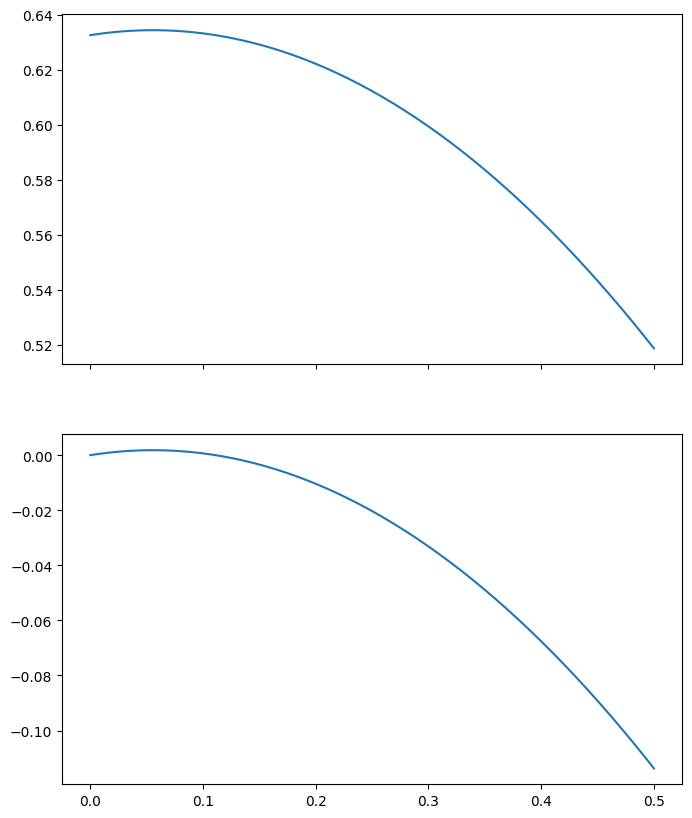

In [50]:
coops = np.linspace(0, 0.5, 200)
values_coop = []
for Coop in coops:
    V_coop = utility_quad(1-Coop, gamma) + delta * (
        p * utility_quad(1+Coop, gamma) + (1 - p) * utility_quad(0+Coop, gamma)
    )
    values_coop.append(V_coop)


diff = np.array(values_coop) - V_wta
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10), sharex=True)
ax1.plot(coops, values_coop)
ax2.plot(coops, diff)

what about the difference ?

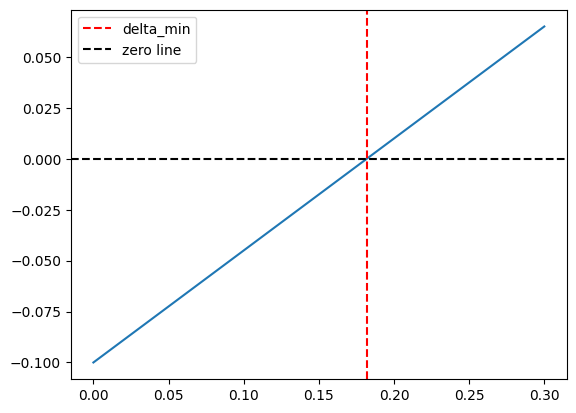

In [64]:
deltas = np.linspace(0., 0.3, 200)

#delta_min = deriv_u_quad(1, gamma) / (
#    p * deriv_u_quad(1, gamma) + (1 - p) * deriv_u_quad(0, gamma)
#)
delta_min = (1 - gamma) / (1 - p* gamma)


diffs = -deriv_u_quad(1, gamma) + deltas * (
    p * deriv_u_quad(1, gamma) + (1 - p) * deriv_u_quad(0, gamma)
)

f, ax = plt.subplots()
ax.plot(deltas, diffs)
ax.axvline(delta_min, color='red', linestyle='--', label='delta_min')
ax.axhline(0, color="black", linestyle="--", label="zero line")
ax.legend()

## Testing the Widget Logic

Translating the JavaScript widget code to Python to verify correctness.

In [67]:
from scipy.stats import norm

# ============================================
# PARAMETERS (equivalent to React state/sliders)
# ============================================

# Slider values
delta = 0.1  # Patience / discount factor (slider: 0.1 to 0.99)
political_security = 0.5  # 0 = Ferreira (fragile), 1 = Lindqvist (secure)

# Constants
GAMMA = 0.8  # Risk aversion parameter
COOP = 0.2  # Cooperation discount (how much is shared)
T = 10  # Number of periods to simulate
n_simulations = 200  # Number of Monte Carlo trajectories

# ============================================
# DERIVED PARAMETERS
# ============================================

# s=0 (Ferreira): X₀=0.52, σ=0.20 → high volatility, near 50%
# s=1 (Lindqvist): X₀=0.70, σ=0.08 → low volatility, comfortable majority
X0 = 0.52 + 0.18 * political_security
sigma = 0.2 - 0.12 * political_security

print(f"X0 = {X0:.2f}, sigma = {sigma:.2f}")

# ============================================
# UTILITY FUNCTION
# ============================================

def utility(y: float) -> float:
    """Quadratic utility: U(Y) = Y - 0.5 * γ * Y²"""
    return y - 0.5 * GAMMA * y * y

# ============================================
# PROBABILITY CALCULATION
# ============================================

def calculate_p(x: float, s: float) -> float:
    """Calculate p: probability that X falls below 0.5 in next step"""
    return norm.cdf((0.5 - x) / s)

current_p = calculate_p(X0, sigma)
print(f"Probability of losing majority: p = {current_p:.4f} ({current_p*100:.1f}%)")

# ============================================
# ANALYTICAL δ_min
# ============================================

# δ_min = (1 - γ) / (1 - p·γ)
delta_min = (1 - GAMMA) / (1 - current_p * GAMMA)
print(f"Analytical δ_min = {delta_min:.4f}")

# ============================================
# SIMULATION
# ============================================

def simulate_trajectory() -> list:
    """Simulate one trajectory of X values (power/majority)"""
    trajectory = [X0]
    x = X0
    for t in range(1, T):
        x = x + sigma * np.random.randn()
        x = max(0, min(1, x))  # Clamp to [0, 1]
        trajectory.append(x)
    return trajectory

# Strategy functions
def strategy_cooperate(x: float) -> float:
    """If majority, share (Y = 1 - COOP), otherwise receive (Y = COOP)"""
    return 1 - COOP if x > 0.5 else COOP

def strategy_wta(x: float) -> float:
    """Winner takes all: Y = 1 if majority, else Y = 0"""
    return 1 if x > 0.5 else 0

def calculate_discounted_utility(trajectory: list, strategy_fn, d: float) -> float:
    """Calculate discounted utility for a trajectory under a strategy"""
    total = 0
    for t, x in enumerate(trajectory):
        y = strategy_fn(x)
        total += (d ** t) * utility(y)
    return total

# ============================================
# RUN MONTE CARLO
# ============================================

np.random.seed(42)  # For reproducibility

trajectories = [simulate_trajectory() for _ in range(n_simulations)]

# Calculate payoffs
coop_payoffs = [calculate_discounted_utility(traj, strategy_cooperate, delta) for traj in trajectories]
wta_payoffs = [calculate_discounted_utility(traj, strategy_wta, delta) for traj in trajectories]

coop_mean = np.mean(coop_payoffs)
coop_std = np.std(coop_payoffs)
wta_mean = np.mean(wta_payoffs)
wta_std = np.std(wta_payoffs)

print(f"\n--- Results for δ = {delta:.2f} ---")
print(f"Cooperate: {coop_mean:.4f} ± {coop_std:.4f}")
print(f"WTA:       {wta_mean:.4f} ± {wta_std:.4f}")
print(f"\nCooperation wins (MC): {coop_mean > wta_mean}")
print(f"Cooperation wins (analytical, δ >= δ_min): {delta >= delta_min}")

X0 = 0.61, sigma = 0.14
Probability of losing majority: p = 0.2160 (21.6%)
Analytical δ_min = 0.2418

--- Results for δ = 0.10 ---
Cooperate: 0.5983 ± 0.0130
WTA:       0.6564 ± 0.0217

Cooperation wins (MC): False
Cooperation wins (analytical, δ >= δ_min): False


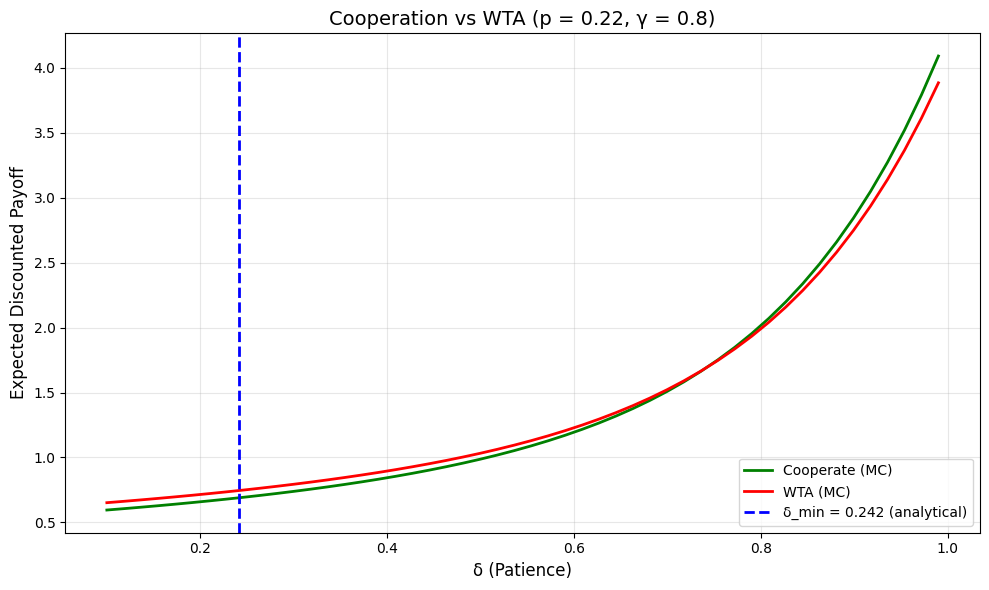


MC crossover at δ ≈ 0.754
Analytical δ_min = 0.242
Difference: 0.5121


In [66]:
# ============================================
# TEST: Sweep delta and compare MC vs analytical
# ============================================

deltas_test = np.linspace(0.1, 0.99, 50)
coop_means = []
wta_means = []

np.random.seed(123)
# Generate trajectories once
test_trajectories = [simulate_trajectory() for _ in range(n_simulations)]

for d in deltas_test:
    coop = [calculate_discounted_utility(traj, strategy_cooperate, d) for traj in test_trajectories]
    wta = [calculate_discounted_utility(traj, strategy_wta, d) for traj in test_trajectories]
    coop_means.append(np.mean(coop))
    wta_means.append(np.mean(wta))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(deltas_test, coop_means, label='Cooperate (MC)', color='green', linewidth=2)
ax.plot(deltas_test, wta_means, label='WTA (MC)', color='red', linewidth=2)
ax.axvline(delta_min, color='blue', linestyle='--', linewidth=2, label=f'δ_min = {delta_min:.3f} (analytical)')

# Mark crossover
ax.set_xlabel('δ (Patience)', fontsize=12)
ax.set_ylabel('Expected Discounted Payoff', fontsize=12)
ax.set_title(f'Cooperation vs WTA (p = {current_p:.2f}, γ = {GAMMA})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find MC crossover point
diff = np.array(coop_means) - np.array(wta_means)
crossover_idx = np.where(diff > 0)[0]
if len(crossover_idx) > 0:
    mc_delta_min = deltas_test[crossover_idx[0]]
    print(f"\nMC crossover at δ ≈ {mc_delta_min:.3f}")
    print(f"Analytical δ_min = {delta_min:.3f}")
    print(f"Difference: {abs(mc_delta_min - delta_min):.4f}")

In [ ]:
# ============================================
# BUG ANALYSIS: The meaning of p is inverted!
# ============================================

# In the original derivation (cell 3):
#   p = probability of WINNING (staying in power)
#   Formula: δ_min = (1-γ) / (1 - p_win·γ)
#
# In the MC widget:
#   current_p = P(X < 0.5) = probability of LOSING
#   p_win = 1 - current_p

# Let's verify with limiting cases:
print("=== Checking δ_min formula ===\n")

# Case 1: Very secure (never lose, p_lose → 0)
# Should give HIGH δ_min (no need to cooperate - you always win!)
p_lose_secure = 0.01
p_win_secure = 1 - p_lose_secure

delta_min_wrong = (1 - GAMMA) / (1 - p_lose_secure * GAMMA)
delta_min_correct = (1 - GAMMA) / (1 - p_win_secure * GAMMA)

print(f"Secure (p_lose = {p_lose_secure}):")
print(f"  Wrong formula (using p_lose):   δ_min = {delta_min_wrong:.3f}")
print(f"  Correct formula (using p_win):  δ_min = {delta_min_correct:.3f}")
print()

# Case 2: Very insecure (often lose, p_lose → 0.5)
p_lose_insecure = 0.46
p_win_insecure = 1 - p_lose_insecure

delta_min_wrong = (1 - GAMMA) / (1 - p_lose_insecure * GAMMA)
delta_min_correct = (1 - GAMMA) / (1 - p_win_insecure * GAMMA)

print(f"Insecure (p_lose = {p_lose_insecure}):")
print(f"  Wrong formula (using p_lose):   δ_min = {delta_min_wrong:.3f}")
print(f"  Correct formula (using p_win):  δ_min = {delta_min_correct:.3f}")
print()

# Now recalculate with CORRECT formula
p_win = 1 - current_p  # Convert p_lose to p_win
delta_min_corrected = (1 - GAMMA) / (1 - p_win * GAMMA)

print(f"=== For our scenario (political_security = {political_security}) ===")
print(f"X0 = {X0:.2f}, sigma = {sigma:.2f}")
print(f"p_lose (current_p) = {current_p:.4f}")
print(f"p_win = {p_win:.4f}")
print(f"OLD δ_min (wrong):  {delta_min:.4f}")
print(f"NEW δ_min (correct): {delta_min_corrected:.4f}")

In [ ]:
# ============================================
# CORRECTED TEST: Sweep delta with correct δ_min
# ============================================

# Use the CORRECTED delta_min
p_win = 1 - current_p
delta_min_corrected = (1 - GAMMA) / (1 - p_win * GAMMA)

# Plot with corrected formula
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(deltas_test, coop_means, label='Cooperate (MC)', color='green', linewidth=2)
ax.plot(deltas_test, wta_means, label='WTA (MC)', color='red', linewidth=2)

# Show BOTH lines
ax.axvline(delta_min, color='orange', linestyle=':', linewidth=2, 
           label=f'δ_min WRONG = {delta_min:.3f}')
ax.axvline(delta_min_corrected, color='blue', linestyle='--', linewidth=2, 
           label=f'δ_min CORRECT = {delta_min_corrected:.3f}')

ax.set_xlabel('δ (Patience)', fontsize=12)
ax.set_ylabel('Expected Discounted Payoff', fontsize=12)
ax.set_title(f'Cooperation vs WTA (p_lose = {current_p:.2f}, p_win = {p_win:.2f}, γ = {GAMMA})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare crossover
diff = np.array(coop_means) - np.array(wta_means)
crossover_idx = np.where(diff > 0)[0]
if len(crossover_idx) > 0:
    mc_delta_min = deltas_test[crossover_idx[0]]
    print(f"\nMC crossover at δ ≈ {mc_delta_min:.3f}")
    print(f"WRONG δ_min = {delta_min:.3f} (error: {abs(mc_delta_min - delta_min):.3f})")
    print(f"CORRECT δ_min = {delta_min_corrected:.3f} (error: {abs(mc_delta_min - delta_min_corrected):.3f})")

In [ ]:
// Derived parameters from political security slider
  // s=0 (Ferreira): X₀=0.52, σ=0.20 → high volatility, near 50%
  // s=1 (Lindqvist): X₀=0.70, σ=0.08 → low volatility, comfortable majority
  const X0 = 0.52 + 0.18 * politicalSecurity;
  const sigma = 0.2 - 0.12 * politicalSecurity;
  
  // Fixed parameters
  const T = 10; // Number of periods to simulate
  const nSimulations = 200; // Number of Monte Carlo trajectories
  const COOP = 0.2; // Cooperation discount (how much is shared)

  // Trigger re-simulation
  const [simKey, setSimKey] = useState(0);

  // Calculate p: probability that X falls below 0.5 in next step
  const calculateP = (x: number, s: number): number => {
    return normalCDF((0.5 - x) / s);
  };

  const currentP = calculateP(X0, sigma);

  // Analytical δ_min: threshold where cooperation becomes rational
  // δ_min = (1 - γ) / (1 - p·γ)
  const deltaMin = (1 - GAMMA) / (1 - currentP * GAMMA);

  // Simulate one trajectory of X values (power/majority)
  const simulateTrajectory = (): number[] => {
    const trajectory: number[] = [X0];
    let x = X0;
    for (let t = 1; t < T; t++) {
      x = x + sigma * gaussianRandom();
      x = Math.max(0, Math.min(1, x)); // Clamp to [0, 1]
      trajectory.push(x);
    }
    return trajectory;
  };

  // Strategy functions: X (power) -> Y (budget allocation for party A)
  // Following notebook model:
  // WTA: If I have majority (X > 0.5), I take everything (Y = 1), otherwise get nothing (Y = 0)
  // Cooperate: If I have majority, I share (Y = 1 - COOP), otherwise I receive (Y = COOP)
  const strategies = {
    cooperate: (x: number) => (x > 0.5 ? 1 - COOP : COOP),
    wta: (x: number) => (x > 0.5 ? 1 : 0),
  };

  // Calculate discounted utility for a trajectory under a strategy
  const calculateDiscountedUtility = (trajectory: number[], strategyFn: (x: number) => number, d: number): number => {
    let total = 0;
    for (let t = 0; t < trajectory.length; t++) {
      const y = strategyFn(trajectory[t]);
      total += Math.pow(d, t) * utility(y);
    }
    return total;
  };

  // Run Monte Carlo simulation for payoff calculation
  const runSimulation = React.useMemo(() => {
    const trajectories = Array.from({ length: nSimulations }, () => simulateTrajectory());

    // Calculate payoffs at current delta
    const results = {
      cooperate: { values: [] as number[], mean: 0, std: 0 },
      wta: { values: [] as number[], mean: 0, std: 0 },
    };

    for (const trajectory of trajectories) {
      results.cooperate.values.push(calculateDiscountedUtility(trajectory, strategies.cooperate, delta));
      results.wta.values.push(calculateDiscountedUtility(trajectory, strategies.wta, delta));
    }

    // Calculate means and standard deviations
    for (const key of ["cooperate", "wta"] as const) {
      const values = results[key].values;
      results[key].mean = values.reduce((a, b) => a + b, 0) / values.length;
      results[key].std = Math.sqrt(
        values.reduce((sum, v) => sum + Math.pow(v - results[key].mean, 2), 0) / values.length,
      );
    }

    return { trajectories, results };
  }, [delta, politicalSecurity, simKey]);

  const { results } = runSimulation;

  // Determine if cooperation is rational (using analytical δ_min)
  const cooperationWins = delta >= deltaMin;